In [1]:
import time
import sys
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bt

from datetime import datetime
import yfinance as yf

In [2]:
tickers_new = 'aapl,msft,c,gs,ge,jnj,pg,ko,amzn,jpm,adbe,ma,dis,txn'
data = bt.get(
    tickers_new,
    start='2010-01-01',
    end = '2024-01-01'
)
data.tail()

out_path = r'C:\Users\natha\OneDrive\Desktop\Rust\atlas\crates\atlas\src\test\data\sp500'
for col in data.columns:
    df_ticker = pd.DataFrame(data[col])
    df_ticker.columns = ["close"]
    df_ticker.to_csv(os.path.join(out_path, col + '.csv'))

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


,aapl,msft,c,gs,ge,jnj,pg,ko,amzn,jpm,adbe,ma,dis,txn
Date,,,,,,,,,,,,,,
2023-12-22,193.353287,373.888580,50.379162,380.649994,126.610497,154.288544,144.368240,58.320000,153.419998,166.374069,598.750000,423.432648,91.019997,166.922775
2023-12-26,192.803986,373.968445,50.854626,381.609985,127.390007,154.963409,145.024109,58.560001,153.410004,167.358017,598.260010,423.003326,90.949997,169.472656
2023-12-27,192.903839,373.379547,50.973488,384.480011,128.199997,155.171844,145.143356,58.709999,153.339996,168.361816,596.080017,423.692200,90.379997,169.889359
2023-12-28,193.333298,374.587280,51.032925,386.410004,128.320007,155.400101,144.815414,58.750000,153.380005,169.256317,595.520020,425.649139,90.400002,170.375534
2023-12-29,192.284637,375.345886,50.953678,385.769989,127.629997,155.558899,145.620331,58.930000,151.940002,169.057541,596.599976,425.838837,90.290001,169.125397


In [4]:
sma = data.rolling(50).mean()

st = time.time()
class SelectWhere(bt.Algo):

    """
    Selects securities based on an indicator DataFrame.

    Selects securities where the value is True on the current date (target.now).

    Args:
        * signal (DataFrame): DataFrame containing the signal (boolean DataFrame)

    Sets:
        * selected

    """
    def __init__(self, signal):
        self.signal = signal

    def __call__(self, target):
        # get signal on target.now
        if target.now in self.signal.index:
            sig = self.signal.loc[target.now]

            # get indices where true as list
            selected = list(sig.index[sig])

            # save in temp - this will be used by the weighing algo
            target.temp['selected'] = selected

        # return True because we want to keep on moving down the stack
        return True
    
signal = data > sma


# first we create the Strategy
s = bt.Strategy('above50sma', [SelectWhere(data > sma),
                               bt.algos.WeighEqually(),
                               bt.algos.Rebalance()])

# now we create the Backtest
t = bt.Backtest(
    s,
    data,
    initial_capital=1000000.0
)

# and let's run it!
res = bt.run(t)
et = time.time()

print(f"Run time: {et-st:.2f} seconds") 
bt_runtime_seconds = et-st
res.display()

Run time: 1.72 seconds
Stat                 above50sma
-------------------  ------------
Start                2010-01-03
End                  2023-12-29
Risk-free rate       0.00%

Total Return         444.62%
Daily Sharpe         0.81
Daily Sortino        1.25
CAGR                 12.88%
Max Drawdown         -33.70%
Calmar Ratio         0.38

MTD                  3.89%
3m                   13.23%
6m                   12.08%
YTD                  36.12%
1Y                   35.78%
3Y (ann.)            4.71%
5Y (ann.)            12.97%
10Y (ann.)           12.25%
Since Incep. (ann.)  12.88%

Daily Sharpe         0.81
Daily Sortino        1.25
Daily Mean (ann.)    13.55%
Daily Vol (ann.)     16.80%
Daily Skew           -0.63
Daily Kurt           5.05
Best Day             5.27%
Worst Day            -8.03%

Monthly Sharpe       0.79
Monthly Sortino      1.31
Monthly Mean (ann.)  13.76%
Monthly Vol (ann.)   17.31%
Monthly Skew         -0.75
Monthly Kurt         1.43
Best Month           12.9

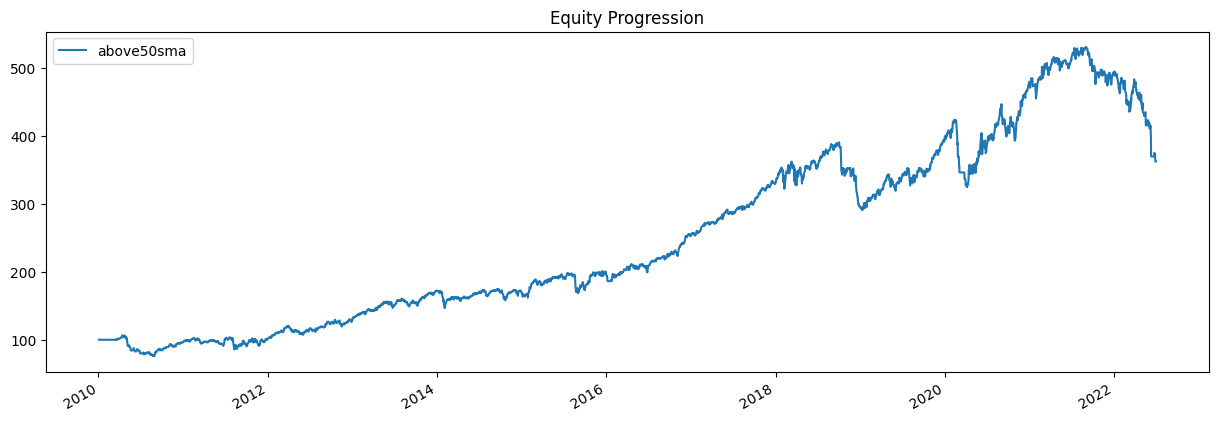

In [73]:
# what does the equity curve look like?
res.plot();

In [74]:
import sys
import time

atlas_path = "C:/Users/natha/OneDrive/Desktop/C++/Atlas/x64/Release"
sys.path.append(atlas_path)

from AtlasPy.core import Hydra, Portfolio, Strategy
from AtlasPy import TracerType
from AtlasPy.ast import AssetReadNode, AssetDifferenceNode, AssetQuotientNode, \
      ExchangeViewNode, AllocationNode, StrategyNode, AssetOpNodeVariant, \
            ExchangeViewFilterType, AllocationType

In [75]:
exchange_id = "test"
portfolio_id = "test_p"
strategy_id = "test_s"
exchange_path_fast = "C:/Users/natha/OneDrive/Desktop/C++/Atlas/AtlasPy/test/data_sp500.h5"
initial_cash = 100.0

hydra = Hydra()
exchange = hydra.addExchange(exchange_id, exchange_path_fast)
portfolio = hydra.addPortfolio(portfolio_id, exchange, initial_cash)
hydra.build()

In [76]:
read_close = AssetReadNode.make("close", 0, exchange)
read_50_ma = AssetReadNode.make("50_ma", 0, exchange)
spread = AssetDifferenceNode(read_close, read_50_ma)
op_variant = AssetOpNodeVariant(spread)

exchange_view = ExchangeViewNode(exchange, op_variant)
exchange_view.setFilter(ExchangeViewFilterType.GREATER_THAN, 0.0)
allocation = AllocationNode(exchange_view)
strategy_node = StrategyNode(allocation, portfolio)
strategy = hydra.addStrategy(
    Strategy(strategy_id, strategy_node, 1.0),
    replace_if_exists=True
)
strategy.enableTracerHistory(TracerType.NLV)

In [77]:
time_sum = 0
n = 1
for i in range(n):
    st = time.perf_counter_ns()
    hydra.run()
    et = time.perf_counter_ns()
    time_sum += et - st

avg_time_micros = (time_sum / n) / 1000

tr = (strategy.getNLV() - initial_cash) / initial_cash
print(f"Time elapsed Avg: {avg_time_micros:.3f} us")
print(f"Total return: {tr:.3%}")
print(f"Epsilon: {tr - 2.6207}")

Time elapsed Avg: 416.100 us
Total return: 262.109%
Epsilon: 0.0003877146672262022


C:\Users\natha\AppData\Local\Temp\ipykernel_20684\2118328846.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_res["Atlas"] = strategy.getHistory(TracerType.NLV)


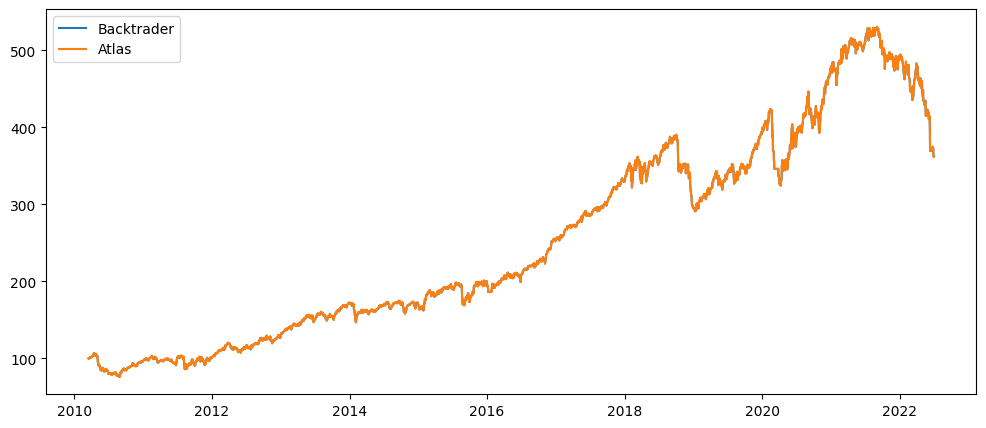

In [78]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)

df_res = res.prices.iloc[50:]
df_res["Atlas"] = strategy.getHistory(TracerType.NLV)

ax.plot(df_res["above50sma"], label='Backtrader')
ax.plot(df_res["Atlas"], label='Atlas')

ax.legend()

In [79]:
tickers_new = 'aapl,msft,c,gs,ge,jnj,pg,ko,amzn,jpm,adbe,ma,dis,txn'
data = bt.get(tickers_new, start='2010-01-01')
sma50 = data.rolling(50).mean()
sma200 = data.rolling(200).mean()
data.shape

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


(3536, 14)

In [124]:
class WeighTarget(bt.Algo):
    def __init__(self, target_weights):
        self.tw = target_weights

    def __call__(self, target):
        if target.now in self.tw.index:
            w = self.tw.loc[target.now]
            target.temp['weights'] = w.dropna()

        return True


st = time.time()

## now we need to calculate our target weight DataFrame
# first we will copy the sma200 DataFrame since our weights will have the same strucutre
tw = sma200.copy()

# set appropriate target weights
tw[sma50 > sma200] = 1.0
tw[sma50 <= sma200] = -1.0

# divide by row sum to normalize
tw = tw.div(tw.abs().sum(axis=1), axis=0)

# replace nans with 0.0
tw[sma200.isnull()] = 0.0

ma_cross = bt.Strategy('ma_cross', [WeighTarget(tw),
                                    bt.algos.Rebalance()])

t = bt.Backtest(
    ma_cross,
    data,
    initial_capital=1000000.0,
    commissions=lambda q, p: 1
)
res = bt.run(t)
et = time.time()
print(f"Run time: {et-st:.2f} seconds")
res.display()

Run time: 2.21 seconds
Stat                 ma_cross
-------------------  ----------
Start                2010-01-03
End                  2024-01-22
Risk-free rate       0.00%

Total Return         104.48%
Daily Sharpe         0.45
Daily Sortino        0.67
CAGR                 5.22%
Max Drawdown         -31.52%
Calmar Ratio         0.17

MTD                  0.88%
3m                   1.50%
6m                   -0.14%
YTD                  0.88%
1Y                   6.21%
3Y (ann.)            5.31%
5Y (ann.)            1.37%
10Y (ann.)           4.84%
Since Incep. (ann.)  5.22%

Daily Sharpe         0.45
Daily Sortino        0.67
Daily Mean (ann.)    5.98%
Daily Vol (ann.)     13.28%
Daily Skew           -0.79
Daily Kurt           22.81
Best Day             10.29%
Worst Day            -10.27%

Monthly Sharpe       0.49
Monthly Sortino      0.75
Monthly Mean (ann.)  5.85%
Monthly Vol (ann.)   12.05%
Monthly Skew         -0.76
Monthly Kurt         1.76
Best Month           9.54%
Worst Mo

In [82]:
output_path = os.path.join(os.getcwd(), 'data_sp500_ma.h5')
if os.path.exists(output_path):
    os.remove(output_path)
    
for ticker in data.columns:
    df = data[ticker].to_frame()
    df["slow_ma"] = sma200[ticker]
    df["fast_ma"] = sma50[ticker]

    with h5py.File(output_path, "a") as file:
        stock_data = df.to_numpy()
        df.columns = ["close", "slow_ma", "fast_ma"]
        index = df.index.values.astype('int64')
        dataset = file.create_dataset(f"{ticker}/data", data=stock_data)
        file.create_dataset(
                f"{ticker}/datetime",
                data = index,
        )
        for column in df.columns:
            dataset.attrs[column] = column

In [83]:
hydra = Hydra()
exchange = hydra.addExchange(exchange_id, output_path)
portfolio = hydra.addPortfolio(portfolio_id, exchange, initial_cash)
hydra.build()

In [84]:
slow_ma = AssetReadNode.make("slow_ma", 0, exchange)
fast_ma = AssetReadNode.make("fast_ma", 0, exchange)
spread = AssetDifferenceNode(fast_ma, slow_ma)
op_variant = AssetOpNodeVariant(spread)

exchange_view = ExchangeViewNode(exchange, op_variant)
allocation = AllocationNode(exchange_view, AllocationType.CONDITIONAL_SPLIT, 0.0, 0.0)
strategy_node = StrategyNode(allocation, portfolio)
strategy = hydra.addStrategy(Strategy(strategy_id, strategy_node, 1.0))
strategy.enableTracerHistory(TracerType.NLV)

In [88]:
time_sum = 0
n = 1
for i in range(n):
    st = time.perf_counter_ns()
    hydra.run()
    et = time.perf_counter_ns()
    time_sum += et - st

avg_time_micros = (time_sum / n) / 1000

tr = (strategy.getNLV() - initial_cash) / initial_cash
print(f"Time elapsed Avg: {avg_time_micros:.3f} us")
print(f"Total return: {tr:.3%}")
print(f"Epsilon: {tr - 1.1098}")

Time elapsed Avg: 415.700 us
Total return: 111.125%
Epsilon: 0.0014480640101524056


C:\Users\natha\AppData\Local\Temp\ipykernel_29344\3759711916.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results["Atlas"] = strategy.getHistory(TracerType.NLV)


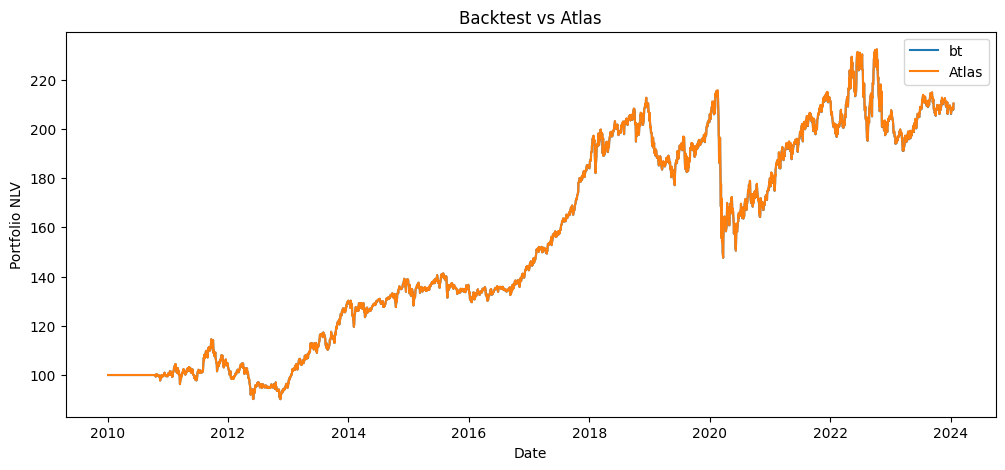

In [28]:
df_results = res.prices
df_results = df_results.iloc[1:]
df_results["Atlas"] = strategy.getHistory(TracerType.NLV)

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
ax.plot(df_results["ma_cross"], label='bt')
ax.plot(df_results["Atlas"], label='Atlas')

ax.set_xlabel('Date')
ax.set_ylabel('Portfolio NLV')
plt.title('Backtest vs Atlas')

_ = ax.legend()

In [5]:
# test buy and hold strategy that fires on the first trading day of the month

runMonthlyAlgo = bt.algos.RunMonthly(
    run_on_first_date=True
)

msft_idx = tickers_new.split(',').index('msft')
amzn_idx = tickers_new.split(',').index('amzn')
jnj_idx = tickers_new.split(',').index('jnj')
weights = np.zeros((len(data.columns)))
weights[msft_idx] = 0.5
weights[amzn_idx] = 0.3
weights[jnj_idx] = 0.2

# algo to set the weights
#  it will only run when runMonthlyAlgo returns true
#  which only happens on the first of every month
weights = pd.Series(weights,index = tickers_new.split(","))
weighSpecifiedAlgo = bt.algos.WeighSpecified(**weights)

# algo to rebalance the current weights to weights set by weighSpecified
#  will only run when weighSpecifiedAlgo returns true
#  which happens every time it runs
rebalAlgo = bt.algos.Rebalance()

# a strategy that rebalances monthly to specified weights
strat = bt.Strategy('static',
    [
        runMonthlyAlgo,
        weighSpecifiedAlgo,
        rebalAlgo
    ]
)

data_short = data.iloc[49:]

# set integer_positions=False when positions are not required to be integers(round numbers)
backtest = bt.Backtest(
    strat,
    data_short,
    integer_positions=False
)

res = bt.run(backtest)

In [6]:
res.display()

Stat                 static
-------------------  ----------
Start                2010-03-15
End                  2022-06-30
Risk-free rate       0.00%

Total Return         1035.86%
Daily Sharpe         1.03
Daily Sortino        1.70
CAGR                 21.86%
Max Drawdown         -27.77%
Calmar Ratio         0.79

MTD                  -6.46%
3m                   -20.40%
6m                   -22.88%
YTD                  -22.16%
1Y                   -12.75%
3Y (ann.)            16.11%
5Y (ann.)            23.20%
10Y (ann.)           24.19%
Since Incep. (ann.)  21.86%

Daily Sharpe         1.03
Daily Sortino        1.70
Daily Mean (ann.)    22.10%
Daily Vol (ann.)     21.51%
Daily Skew           0.05
Daily Kurt           5.95
Best Day             10.31%
Worst Day            -10.01%

Monthly Sharpe       1.18
Monthly Sortino      2.53
Monthly Mean (ann.)  21.54%
Monthly Vol (ann.)   18.20%
Monthly Skew         0.11
Monthly Kurt         0.60
Best Month           17.77%
Worst Month        

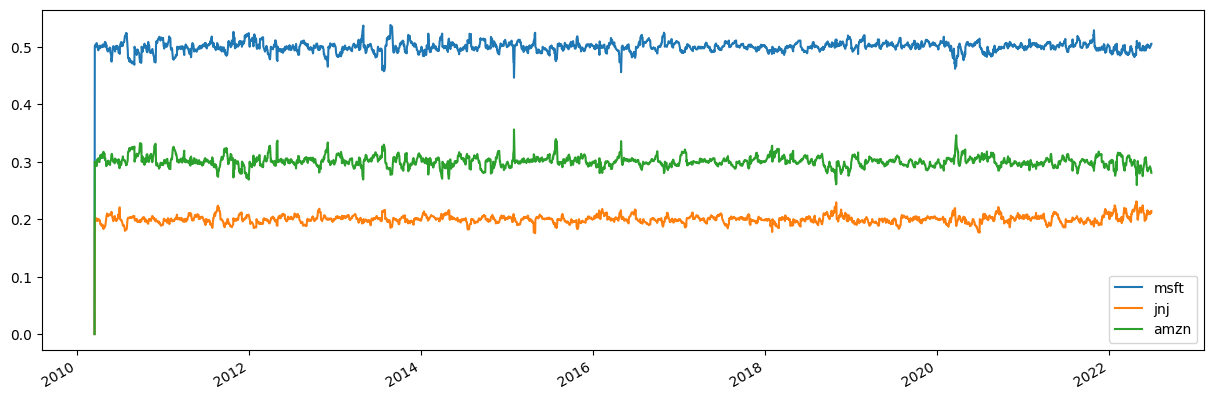

In [19]:
res.plot_security_weights()

In [13]:
from AtlasPy.ast import FixedAllocationNode, StrategyMonthlyRunnerNode
from AtlasPy import TracerType

In [17]:
hydra = Hydra()
exchange = hydra.addExchange(exchange_id, exchange_path_fast)
portfolio = hydra.addPortfolio(portfolio_id, exchange, initial_cash)
hydra.build()

In [18]:
allocation = FixedAllocationNode.make(
    [("msft", .5), ("amzn", .3), ("jnj", .2)],
    exchange,
    0.0
)
strategy_node = StrategyNode(allocation, portfolio)
monthly_trigger_node = StrategyMonthlyRunnerNode.make(exchange)
strategy_node.setTrigger(monthly_trigger_node)
strategy = hydra.addStrategy(Strategy(strategy_id, strategy_node, 1.0))
strategy.enableTracerHistory(TracerType.NLV)
strategy.enableTracerHistory(TracerType.WEIGHTS)

In [20]:
st = time.perf_counter_ns()
hydra.run()
et = time.perf_counter_ns()

avg_time_micros = (et-st) / 1000

tr = (strategy.getNLV() - initial_cash) / initial_cash
print(f"Time elapsed Avg: {avg_time_micros:.3f} us")
print(f"Total return: {tr:.3%}")
print(f"Epsilon: {tr - 10.3586}")

Time elapsed Avg: 549.100 us
Total return: 1035.857%
Epsilon: -2.5235755904517987e-05


In [21]:
x = pd.DataFrame(strategy.getWeightHistory().T)
x = x[[11,7,2]]
x.head(15)

,11,7,2
0,0.000000,0.000000,0.000000
1,0.500000,0.200000,0.300000
2,0.502530,0.199619,0.297852
3,0.500116,0.200055,0.299829
4,0.502607,0.201342,0.296052
5,0.502570,0.201228,0.296202
6,0.505902,0.201465,0.292633
7,0.506330,0.201304,0.292366
8,0.502004,0.196641,0.301355
9,0.498991,0.197186,0.303823


In [12]:
y = res.get_weights()
y = y[y.columns[1:]].iloc[0:-1]
y.head(15)

,static>msft,static>jnj,static>amzn
2010-03-15,0.000000,0.000000,0.000000
2010-03-16,0.500000,0.200000,0.300000
2010-03-17,0.502530,0.199619,0.297852
2010-03-18,0.500117,0.200055,0.299828
2010-03-19,0.502607,0.201342,0.296052
2010-03-22,0.502570,0.201228,0.296202
2010-03-23,0.505902,0.201465,0.292633
2010-03-24,0.506330,0.201303,0.292366
2010-03-25,0.502004,0.196641,0.301355
2010-03-26,0.498991,0.197185,0.303823


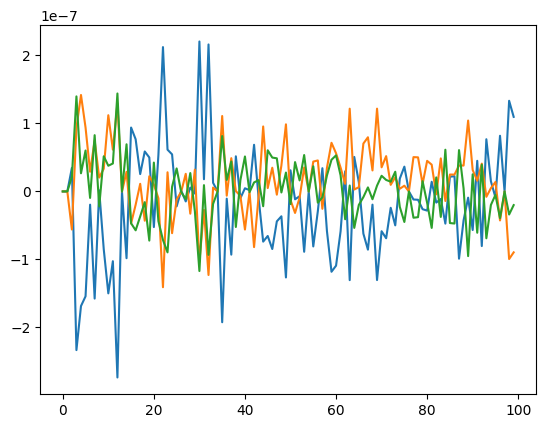

In [22]:
n = 100
plt.plot(x.values[0:n] - y.values[0:n])

C:\Users\natha\AppData\Local\Temp\ipykernel_4288\2679082280.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_results["Atlas"] = strategy.getHistory(TracerType.NLV)


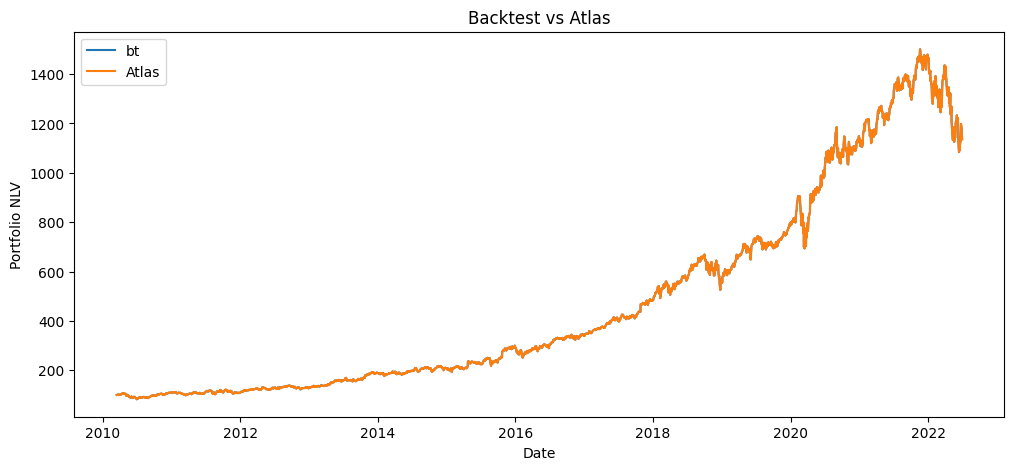

In [23]:
df_results = res.prices
df_results = df_results.iloc[1:]
df_results["Atlas"] = strategy.getHistory(TracerType.NLV)

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(111)
ax.plot(df_results["static"], label='bt')
ax.plot(df_results["Atlas"], label='Atlas')

ax.set_xlabel('Date')
ax.set_ylabel('Portfolio NLV')
plt.title('Backtest vs Atlas')

_ = ax.legend()

In [26]:
offset = pd.DateOffset(months=1)
offset + pd.to_datetime('2021-01-01')


Timestamp('2021-02-01 00:00:00')

In [24]:
# get current nanosecond epoch time
now = pd.Timestamp.now().to_numpy().astype('int64') * 1000
now + offset

1708431509808919000

In [38]:
x_price = 20
x_weight = 0.49751243781094534
cash = 100
fee = 0.01

fee_amount = cash * x_weight * fee
x_value = cash * x_weight
cash -= fee_amount
x_value / cash


0.5000000000000001

In [9]:
x_price = 20
x_weight = .5
cash = 100
fee = 0.01

fee_amount = cash * x_weight * fee
(cash - fee_amount) * .5

49.75

In [47]:
import numpy as np

In [63]:
"""
p1 = 100
(w * p1) / (p1 - .01*w*p1) = .5
(w * 100) = .5 * (100 - w)
100w = 50 - .5w
100.5w = 50
w = 50 / 100.5
0.4975124378109453
"""

def get_commission_scaled_weight(w, f):
    return w / (1 + w*f)

w = np.array([.3,.7])
nlv = 100
fee = .01
new_weights = get_commission_scaled_weight(w, fee)

fees = (w * nlv * fee).sum()
nlv -= fees
nlv

99.0

In [68]:
(new_weights*nlv) / 100

array([0.29611167, 0.68818272])